In [1]:
# Created on Monay 1 July 2019 by Claudio Bellani
# numerical experiments for my paper "Mechanics of good trade execution in the framework of linear temporary market impact"

In [1]:
import numpy as np

import pandas as pd

import scipy

import pickle

from scipy.stats import norm as normalDistribution

from scipy.stats import expon as exponentialDistribution

from scipy.stats import pareto 

from scipy.stats import bernoulli

from scipy.stats import cauchy as cauchyDistribution

from scipy.stats import t as tStudent

from fbm import FBM

import matplotlib.pyplot as plt

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import normalize

from mpl_toolkits.mplot3d import Axes3D 

from termcolor import colored

from scipy import optimize

from numpy.polynomial.polynomial import*

import datetime

In [2]:
font = {'size'   : 16}

plt.rc('font', **font)

In [3]:
import times_

from times_ import randomSign

import gte

In [4]:
dateTime=datetime.datetime.now()

In [5]:
with open('param_gte_AAPL','rb') as source:
    param_AAPL=pickle.load(source)

In [13]:
initialInventory=10*param_AAPL['bidVolume'].max()
liquidationTarget=0.0
date='2019-01-31'
initialPrice=param_AAPL[param_AAPL.date==date].initial_price.values
terminalValue=0.975*initialPrice
asset_class='equity'
stochastic_process='aBM'
volatility=param_AAPL['volatility'].max()
coeffMarketImpact=4.95e-01
coeffRiskAversion=9.50e-01

initialTime=0.0
timeHorizon=1.0
timeHorizon_price=2.0
numberOfPartitionPoints=5000
hurst_exponent=0.36


sampling fBM, with H=0.36


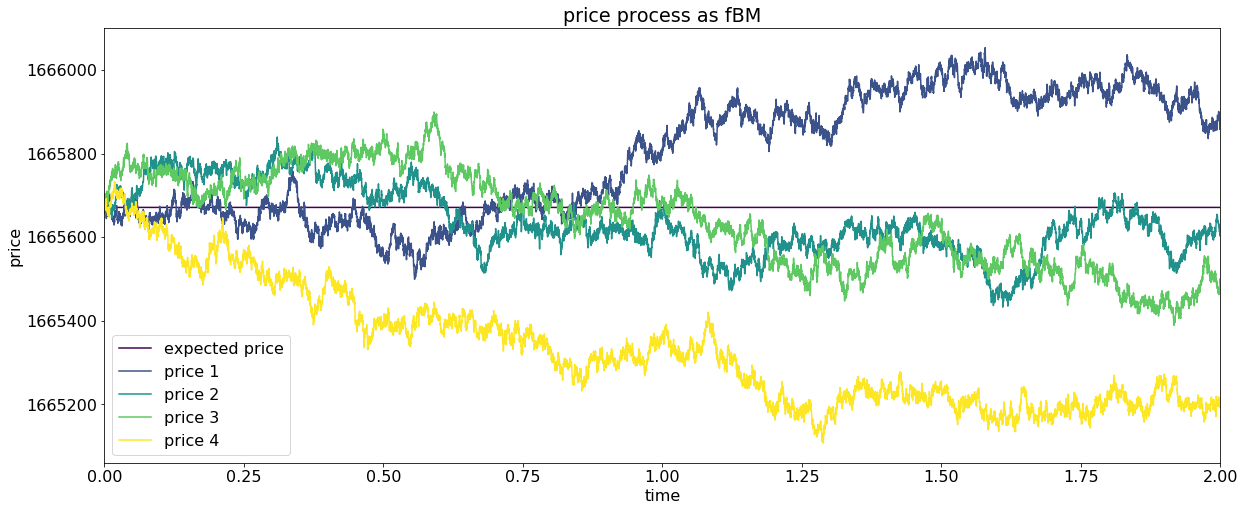

In [14]:
timeWindow_execution=np.linspace(initialTime,timeHorizon,num=numberOfPartitionPoints)
timeWindow_price,is_timeWindow_execution=times_.mergeGrids(timeWindow_execution,
                                   np.linspace(timeHorizon,timeHorizon_price,num=numberOfPartitionPoints))

priceProcess=gte.price(timeWindow_price,
                   initialPrice=initialPrice,
                   terminalValue=terminalValue,
                   volatility=volatility,
                   hurst_exponent=hurst_exponent,
                   stochastic_process=stochastic_process,
                   num_of_simulations=50,
                   plot_price=True)



In [9]:
# with open('priceProcess_aBM_{}_{}h{}m'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(priceProcess,outfile)

In [15]:
inventory_label=gte.produce_labelsForInventories(n=priceProcess.pricePaths.shape[1]-1)
termination_times=pd.DataFrame(np.ones((1,priceProcess.pricePaths.shape[1])),
                       columns=inventory_label)
errorOfLiquidation=pd.DataFrame(np.ones((1,priceProcess.pricePaths.shape[1])),
                       columns=inventory_label)
xi=pd.DataFrame(np.ones((1,priceProcess.pricePaths.shape[1])),
                       columns=inventory_label)
core_execution=pd.DataFrame(np.ones((timeWindow_execution.shape[0],priceProcess.pricePaths.shape[1])),
                       columns=inventory_label,
                       index=priceProcess.pricePaths.index[priceProcess.pricePaths.index<=timeHorizon])
trajectories=pd.DataFrame(np.zeros((timeWindow_execution.shape[0],1)),
                          index=priceProcess.pricePaths.index[priceProcess.pricePaths.index<=timeHorizon])

i=0
for col in priceProcess.pricePaths.columns:
    execution=gte.liquidation(priceProcess.pricePaths[col],
                          priceProcess.expectedPricePath,
                          initialInventory=initialInventory,
                          liquidationTarget=liquidationTarget,
                          coeffMarketImpact=coeffMarketImpact,
                          coeffRiskAversion=coeffRiskAversion,
                          initialTime=initialTime,
                          timeHorizon=timeHorizon,
                          method_extensionOfInventoryTrajectory='eulerLagrange')
#     print('is_StaticInPathwiseNeighbourhood={}'.format(execution.is_StaticInPathwiseNeighbourhood))
    termination_times.iloc[:,i]=execution.terminationTime
    errorOfLiquidation.iloc[:,i]=execution.errorOfLiquidation
    xi.iloc[:,i]=execution.xi
    trajectories=pd.concat([trajectories,execution.trajectory],axis=1,sort=False)
    core_execution.iloc[:,i]=execution.core_inventoryTrajectory
    i+=1



trajectories=trajectories.iloc[:,1:]
trajectories.columns=inventory_label

In [11]:
# with open('inventory_trajectory_AAPL_aBM_{}_{}h{}m'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(trajectories,outfile)

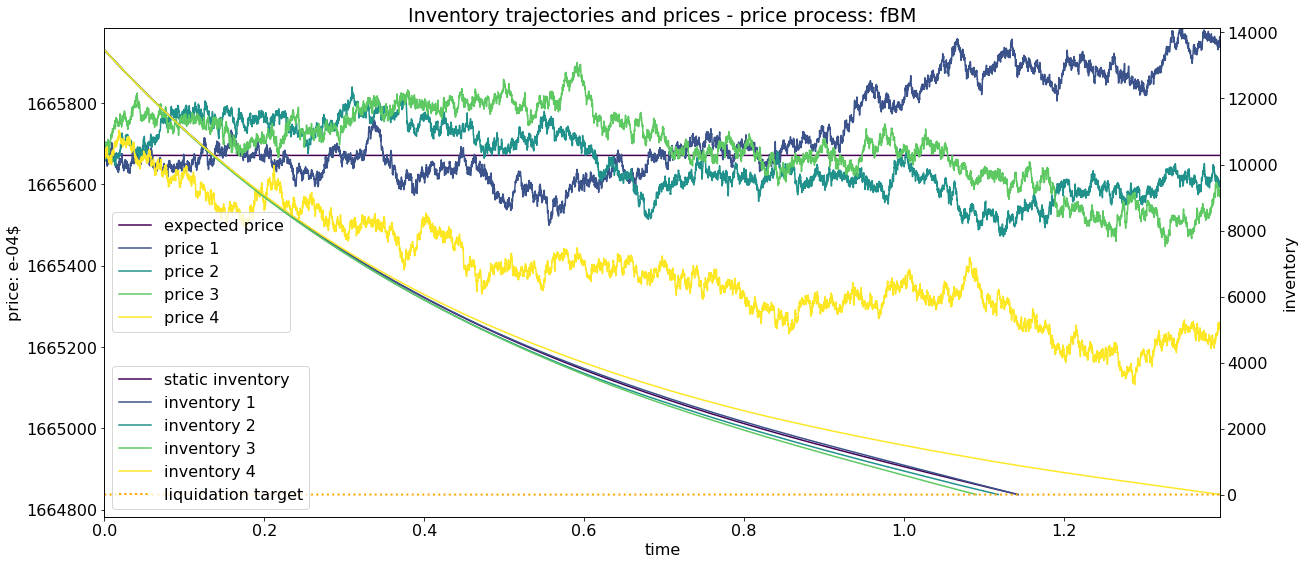

In [16]:
fig = plt.figure(figsize=(20, 9))
cmap = plt.get_cmap('viridis')
ax_price= fig.add_subplot(111)

if not (asset_class=='bond'):
    priceProcess.pricePaths.loc[:trajectories.index[-1]].plot(ax=ax_price,colormap=cmap)
    ylim=[0.999805*np.amin(priceProcess.pricePaths.loc[:trajectories.index[-1]].values),
      np.amax(priceProcess.pricePaths.loc[:trajectories.index[-1]].values)]
else:
    priceProcess.pricePaths.plot(ax=ax_price,colormap=cmap)
    ylim=[0.9*np.amin(priceProcess.pricePaths.values),
          np.amax(priceProcess.pricePaths.values)]

ax_price.set_ylim(ylim)
ax_price.set_xlabel('time')
ax_price.set_ylabel('price: e-04$')





ax_inventory=ax_price.twinx()

trajectories.plot(ax=ax_inventory,colormap=cmap)

if not (asset_class=='bond'):
    ax_inventory.plot(timeWindow_price[:trajectories.shape[0]],
                      liquidationTarget*np.ones(trajectories.shape[0]),
                      color='orange',linewidth=2.0,label='liquidation target',ls=':')
else:
    ax_inventory.plot(timeWindow_price,
                      liquidationTarget*np.ones(timeWindow_price.shape[0]),
                      color='orange',linewidth=2.0,label='liquidation target',ls=':')
ax_inventory.set_ylabel('inventory')
ax_inventory.set_xlabel('time')
ax_inventory.legend(loc=3)
ax_price.legend(loc=6)

plt.title('Inventory trajectories and prices - price process: {}'.format(stochastic_process))
plt.show()

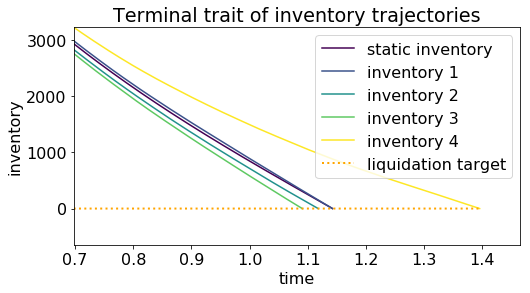

In [17]:
fig = plt.figure(figsize=(8, 4))
cmap = plt.get_cmap('viridis')
ax= fig.add_subplot(111)


trajectories.plot(ax=ax,colormap=cmap)

ax.plot(timeWindow_price[:trajectories.shape[0]],
        liquidationTarget*np.ones(trajectories.shape[0]),
        color='orange',linewidth=2.0,label='liquidation target',ls=':')

xlim=[0.5*trajectories.index[-1],1.05*trajectories.index[-1]]
h=np.amax(trajectories.loc[xlim[0]:xlim[1]].max().values)
ylim=[-0.20*h, h]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('inventory')
ax.set_xlabel('time')
ax.legend()


plt.title('Terminal trait of inventory trajectories')
plt.show()

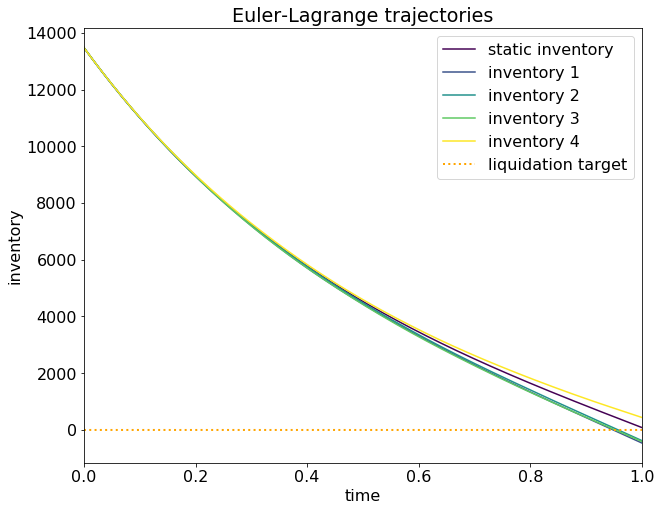

In [14]:
fig = plt.figure(figsize=(10, 8))
ax_inventory= fig.add_subplot(111)
core_execution.plot(ax=ax_inventory,colormap=cmap)
ax_inventory.set_xlabel('time')
ax_inventory.set_ylabel('inventory')
ax_inventory.plot(timeWindow_execution,
                  liquidationTarget*np.ones_like(timeWindow_execution),
                  color='orange',linewidth=2.0,label='liquidation target',ls=':')
plt.title('Euler-Lagrange trajectories')
ax_inventory.legend()
plt.show()

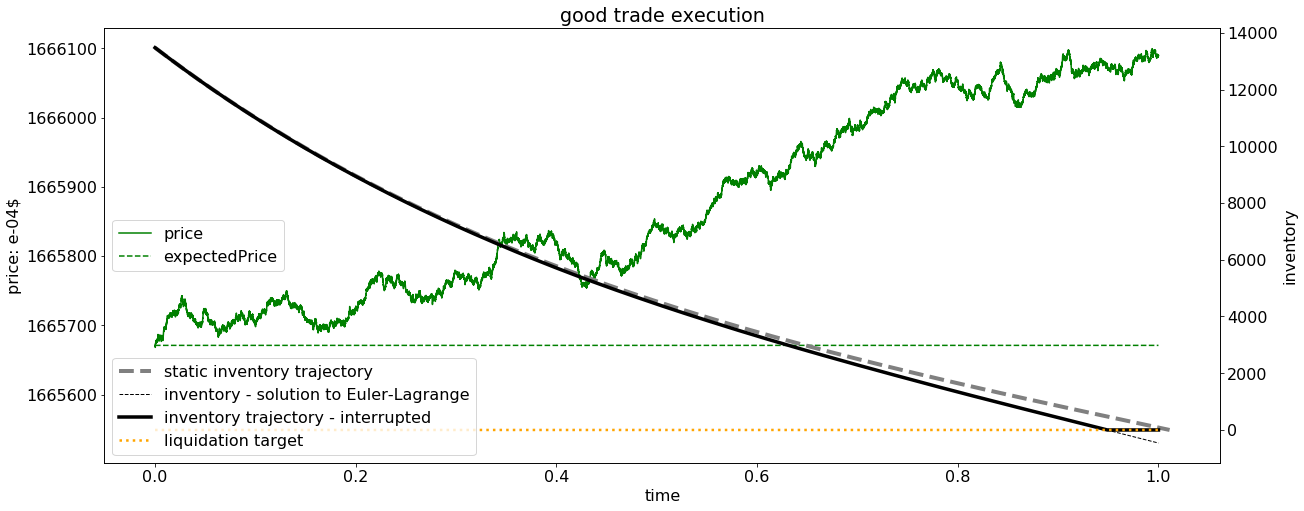

In [15]:
fig = plt.figure(figsize=(20, 8))

ax_price= fig.add_subplot(111)

ax_price.plot(priceProcess.pricePath_high.loc[:timeHorizon],
        label='price',color='green')
# ax_price.plot(timePartition,executionPrice,
#         label='execution price',color='red')
ax_price.plot(priceProcess.expectedPricePath.loc[:timeHorizon],
        label='expectedPrice',color='green',ls='--')
ax_price.set_xlabel('time')
ax_price.set_ylabel('price: e-04$')
ylim=[0.99990*np.amin(priceProcess.pricePath_high.loc[:trajectories.index[-1]].values),
      np.amax(priceProcess.pricePath_high.loc[:trajectories.index[-1]].values)]
ax_price.set_ylim(ylim)

ax_inventory=ax_price.twinx()

ax_inventory.plot(trajectories['static inventory'],
        label='static inventory trajectory',color='grey',ls='--',linewidth=4)
ax_inventory.plot(core_execution['inventory 1'],
        label='inventory - solution to Euler-Lagrange',color='black',linewidth=1,ls='--')
ax_inventory.plot(trajectories['inventory 1'],
        label='inventory trajectory - interrupted',color='black',linewidth=3.5)
ax_inventory.plot(timeWindow_execution,
                  liquidationTarget*np.ones_like(timeWindow_execution),
                  color='orange',linewidth=2.5,label='liquidation target',ls=':')
# if (is_liquidationTerminated):
#     ax_inventory.scatter(terminationTime,liquidationTarget,label='termination time',linewidth=1,facecolor='r',edgecolor='r')
            
ax_inventory.set_ylabel('inventory')
ax_inventory.set_xlabel('time')
ax_inventory.legend(loc=3)
ax_price.legend(loc=6)

plt.title('good trade execution')
plt.show()

In [16]:
def compute_termination(price_path):
    price_path=pd.Series(price_path,index=priceProcess.pricePaths.index)
    execution=gte.liquidation(price_path,
                          priceProcess.expectedPricePath,
                          initialInventory=initialInventory,
                          liquidationTarget=liquidationTarget,
                          coeffMarketImpact=coeffMarketImpact,
                          coeffRiskAversion=coeffRiskAversion,
                          initialTime=initialTime,
                          timeHorizon=timeHorizon,
                          method_extensionOfInventoryTrajectory='eulerLagrange',
                          compute_costFunctional=False,
                          compute_revenues=False)
    output=np.array([execution.terminationTime, execution.errorOfLiquidation])
    return output

In [21]:
list_pricePaths=list((priceProcess.samples.values.T))
ter=map(compute_termination,list_pricePaths)
ter=np.vstack(list(ter))
terminationData=pd.DataFrame({'completion_time':ter[:,0],'liquidation_error':ter[:,1]})

In [18]:
with open('terminationData_aBM_{}_{}h{}m'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
    pickle.dump(terminationData,outfile)

In [19]:
terminationData.describe()

,completion_time,liquidation_error
count,100.000000,100.000000
mean,1.004648,21.534005
std,0.029935,226.002369
min,0.946919,-467.425500
25%,0.986285,-107.838230
50%,1.001810,14.107011
75%,1.023695,178.388325
max,1.093882,606.171352


NameError: name 'completion_time' is not defined

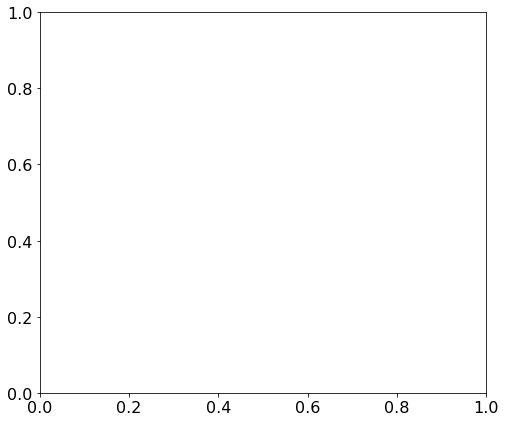

In [20]:
fig = plt.figure(figsize=(8, 7))

ax= fig.add_subplot(111)

terminationData.completion_time.hist(ax=ax,bins=80)
ax.set_title('Termination time of liquidation, time horizon T = {:.1f}'.format(timeHorizon))
ax.set_xlabel('time')
ax.set_ylabel('frequency')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 7))

ax= fig.add_subplot(111)

terminationData.liquidation_error.hist(ax=ax,bins=80,color='m')
ax.set_title('Error of liquidation at time horizon T = {:.1f}'.format(timeHorizon))
ax.set_xlabel('inventory left to liquidate')
ax.set_ylabel('frequency')
plt.show()

In [ ]:
variables_liquidation_aBM={}
variables_liquidation_aBM['initial_inventory']=initialInventory
variables_liquidation_aBM['liquidation_target']=liquidationTarget
variables_liquidation_aBM['initial_price']=initialPrice
variables_liquidation_aBM['price_process']='aBM'
variables_liquidation_aBM['volatility']=volatility
variables_liquidation_aBM['coeff_marketImpact']=coeffMarketImpact
variables_liquidation_aBM['coeff_riskAversion']=coeffRiskAversion


In [ ]:
cols={'initial_inventory',
      'liquidation_target',
      'initial_price',
      'price_process','volatility',
      'coeff_marketImpact','coeff_riskAversion'}
variables_liquidation_aBM=pd.DataFrame(variables_liquidation_aBM,columns=cols)

In [ ]:
with open('variables_liquidation_aBM_{}_{}h{}m'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
    pickle.dump(variables_liquidation_aBM,outfile)